In [45]:
import control
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (10, 5)

In [46]:
def my_root_locus(G, kvect=None):
    "custom function for plotting rlocus, control library version is problematic"
    rlist, klist = control.rlocus(G, kvect=kvect, plot=False);
    poles = control.pole(G)
    zeros = control.zero(G)
    plt.plot(np.real(rlist), np.imag(rlist));
    plt.plot(np.real(poles), np.imag(poles), '.', ms=10, marker='x', mew=1, label='open loop poles')
    plt.plot(np.real(zeros), np.imag(zeros), '.', ms=10, marker='o', mew=1, label='open loop zeros')
    r0, k0 = control.rlocus(G, kvect=[1], plot=False);
    plt.plot(np.real(r0[0]), np.imag(r0[0]), '.', ms=10, marker='s', fillstyle='none', mew=1, label='closed loop poles');
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.grid();
    plt.legend()
    plt.axis('equal')

In [47]:
# Moment of inertias

Ixx = 43791.487  # kg-m2
Iyy = 26276.809  # kg-m2
Izz = 64178.788  # kg-m2

# Fan Model

Fan 1st order plant model, taking into account spool up time.

$G_{fan} = \dfrac{F}{u_{fan}} = F_{max} \dfrac{\tau}{s + \tau}$

where:

* $F_{max}$ is the fan maximum thrust (for Rolls Royce Pegasus 71.22 kN)
* $\tau$ is the spool up/spool down time for the fan, assumed to be the same here
* $u_{fan}$ is the normalized [-1,1] throttle command for the fan

For the spool up/down time, there is a requirement for aircrafts to be able to acheive thrust power from idle to TOGA in 6 seconds.

Thus, it would be realistic to use values of 10 - 12 seconds for the aircraft to get $F_{max}$

In [39]:
tau = 5
thrust_max = 71.22e3  # actual value is 71.22e3 [N]
s = control.tf([1, 0], [1])
G_fan = thrust_max*(tau/(s+tau))
G_fan

TransferFunction(array([356100.]), array([1, 5]))

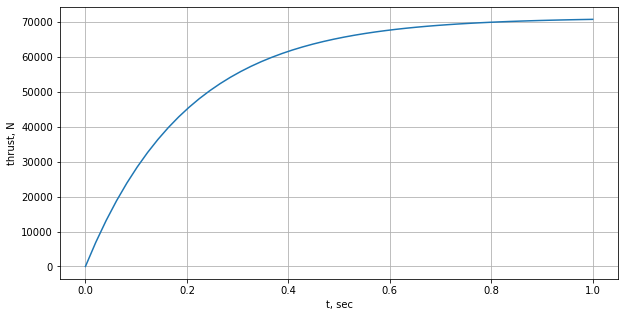

In [41]:
t, y = control.step_response(G_fan, T=np.linspace(0, 1));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('thrust, N')
plt.grid()

# Kinematic Model of Aicraft Roll

$M = J_{xx} \ddot{\phi}$

$M = J_{xx} s^2 \Phi$

$G_{roll} = \dfrac{\Phi}{M} = \dfrac{1}{J_{xx} s^2}$

# Mixing

$M = l(F_l - F_r)$

$M = l(G_{fan}u_{l} - G_{fan} u_{r})$

$u_{roll} = u_{l} - u_{r}$

$\dfrac{M}{u_{roll}} = l G_{fan}$

where:

* $l$ is the distance from the center of mass to the left and right lift fans, assumed to be at the same distance
* $F_{l/r}$ is the thrust of the left/right lift fan
* $u_{l/r}$ is the normalized [-1,1] throttle command for the left/right lift fan
* $u_{roll}$ is the normalized [-1,1] roll mix that we define

# Plant Model

$G = \dfrac{\Phi}{u_{roll}} =  \dfrac{\Phi}{M} \times \dfrac{M}{u_{roll}} = \dfrac{l G_{fan}}{J_{xx} s^2} = \dfrac{lF_{max}\tau}{J_{xx}s^2(s+\tau)}$

In [42]:
l = 3.68
Jxx = Iyy + Izz
Gk = 1/(Jxx*s**2)  # Plant for the "k"inematics
Gf = l*G_fan  # Plant for the "f"an
G = Gf * Gk
G

TransferFunction(array([1310448.]), array([ 90455.597, 452277.985,      0.   ,      0.   ]))

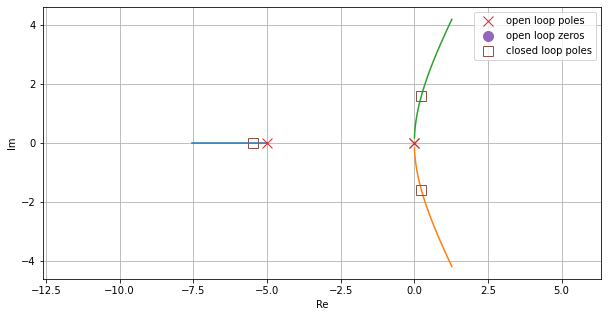

In [7]:
my_root_locus(G, kvect=np.logspace(-2, 1, 1000));

# PID controller

We will do the controller design with MATLAB SIMULINK

The design requirements for the system will be defined to be the following for a step response 
$\zeta =0\ldotp 7071$

$t_s =1.0$

Which imply 

$\%OS=exp{\left(\frac{-\zeta \pi }{\sqrt{1-\zeta {\;}^2 }}\right)}\times 100 = 4.3217 \%$

$\text{time constant} := {4.6}\tau = t_s \leq 1.0 s$
$\Rightarrow \tau \leq 0.2174$


Now using the Control System Tuner of MATLAB we can design a PID with the following gains 

$K_p +K_i \frac{1}{s}+K_d \frac{s}{T_f s+1}$

<span style="color:red">CAUTION: THESE VALUES CORRESPOND TO THE PARAMETERS THAT PROF GOPPERT SET!</span>

$where \phantom{-} K_p =1.8148\text{e}-5, \phantom{-} K_i =1.8117\text{e}-10,\phantom{-} K_d =0.3130,\phantom{-} T_f =0.0421$

for the system without the noise and disturbance included during the tuning

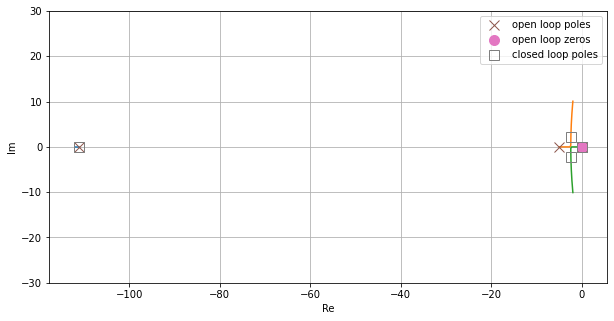

In [9]:
# H = 0.29*(s/1 + 1)/(s/30 + 1)  # lead-lag

kp = 2.27819592159632e-07 
ki = 1.69145522308596e-10
kd = 0.736203952699017
N = 111.055675353426
H = kp + ki / s + kd * (N / (1 + N * (1 / s)))

my_root_locus(G*H, np.logspace(-10, 1, 1000))

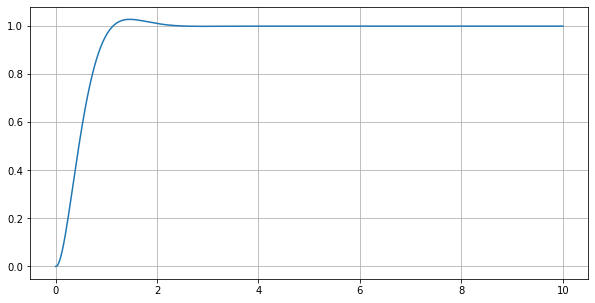

In [10]:
y_r = G*H/(1 + G*H)
t, y = control.step_response(y_r, T=np.linspace(0, 10, 1000))
plt.plot(t, y)
plt.grid()

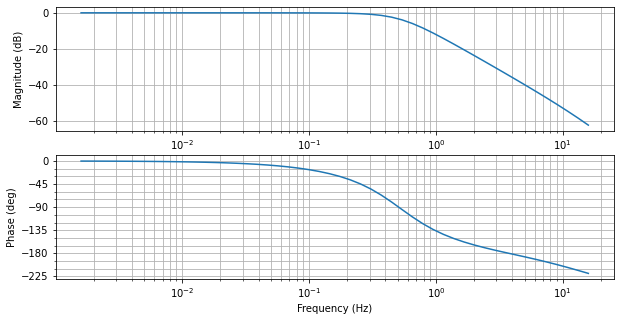

In [11]:
control.bode(y_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

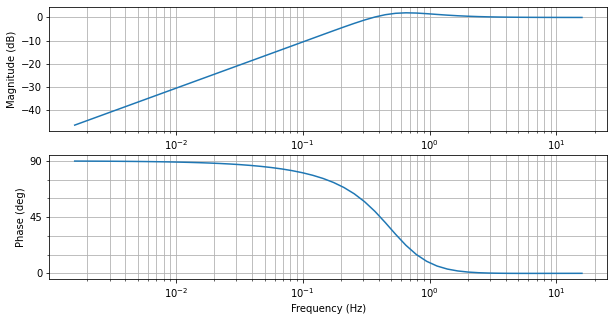

In [12]:
e_r = 1/(1 + G*H)
control.bode(e_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

The maximum magnitude is (dB)
1.2584204661266056
The corresponding frequency is (Hz)
3.927337601864448


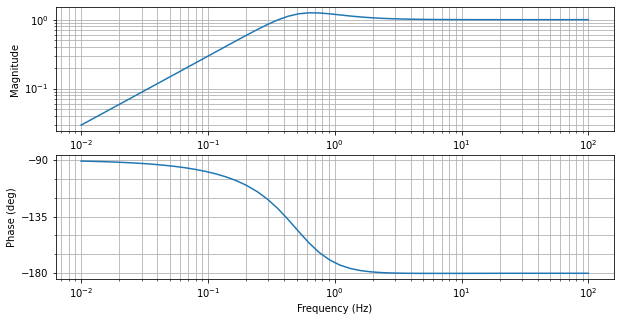

In [13]:
e_n = -1/(1 + Gk*Gf*H)
mag, phase, omega = control.bode(e_n, omega=2*np.pi*np.logspace(-2, 2), Hz=True);

mag = np.array(mag)
omega = np.array(omega)
max_idx = np.argmax(mag)
print("The maximum magnitude is (dB)")
print(mag[max_idx])
print("The corresponding frequency is (Hz)")
print(omega[max_idx])

The maximum magnitude is (dB)
1.2606548228396843
The corresponding frequency is (Hz)
4.094915062380423

The gain margin [dB]:
inf
The phase margin [Hz]:
-179.1106454872922

The maximum amplitude is:
1.156199403930316


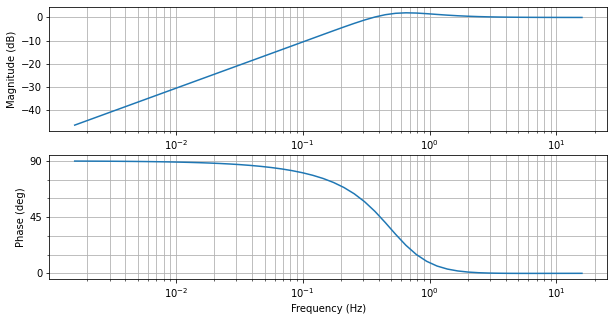

In [15]:
e_d = 1/(1 + G*H)
mag, phase, omega = control.bode(e_d, omega=np.logspace(-2, 2), Hz=True, dB=True);

mag = np.array(mag)
omega = np.array(omega)
max_idx = np.argmax(mag)
print("The maximum magnitude is (dB)")
print(mag[max_idx])
print("The corresponding frequency is (Hz)")
print(omega[max_idx])


# Obtain the phase margins and gain margins 
gm, pm, sm, wg, wp, ws = control.stability_margins((mag, phase, omega))
print("\nThe gain margin [dB]:")
print(gm)
print("The phase margin [Hz]:")
print(pm)


# Compute the maximum amplitude from the bode plot 
Amax = 10 ** (mag[max_idx] / 20)
print("\nThe maximum amplitude is:")
print(Amax)

# Gang of 4

* $\dfrac{GH}{1 + GH}$ the complementary sensitivity function
* $\dfrac{G}{1 + GH}$ the load disturbance sensitivity function
* $\dfrac{H}{1 + GH}$ the noise sensitivity function
* $\dfrac{1}{1 + GH}$ the sensitivity function

# Yaw Control 

Since the pitch control of the 2 front engines are controlled by motors we can approximate the model for those controls as a first order transfer function as follows.

$$
G_p = 
\begin{cases}
    G_{lp} = \dfrac{\theta_l}{u_{lp}} = \theta_{max} \dfrac{\tau_p}{s+\tau_p}\\
    G_{rp} = \dfrac{\theta_r}{u_{rp}} = \theta_{max} \dfrac{\tau_p}{s+\tau_p}
\end{cases}
$$

where 

$$
\begin{align}
    \theta_l &:= \text{pitch angle for left engine}\\
    \theta_r &:= \text{pitch angle for right engine }\\
    u_{lp} &:= \text{left engine angle command normalized to [-1,1]}\\
    u_{rp} &:= \text{right engine angle command normalized to [-1,1]}\\
    \theta_{max} &:= \text{maximum angle for the engine pitch}\\
    \tau_p &:= time constant for the pitch controlling motor
\end{align}
$$

In [68]:
tau_p = 2
theta_max = 120 / 180 * np.pi  # radians 
s = control.tf([1, 0], [1])
G_p = theta_max*(tau_p/(s+tau_p))
G_p

TransferFunction(array([4.1887902]), array([1, 2]))

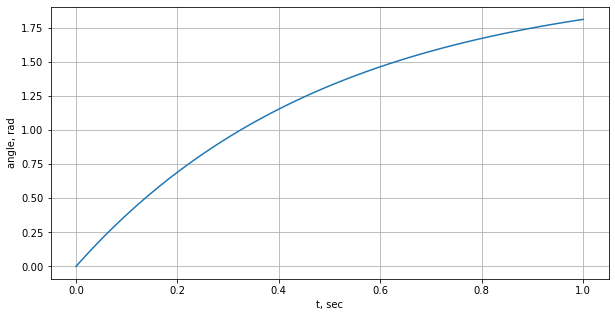

In [69]:
t, y = control.step_response(G_p, T=np.linspace(0, 1));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('angle, rad')
plt.grid()


## Kinematic Model of Aicraft yaw

$M = J_{zz} \ddot{\psi}$

$M = J_{zz} s^2 \Psi$

$G_{yaw} = \dfrac{\Psi}{M} = \dfrac{1}{J_{zz} s^2}$

## Mixing 

$M = l(F_r\sin{\theta_r} - F_l\sin{\theta_l})$

say $F = F_r = F_l =$ const.

and also $\sin{\theta} \approx \theta$

$M \approx lF(\theta_r - \theta_l)$

$M = lF(G_p u_{rp} - G_p u_{lp}) $ 

$u_{yaw} = u_{rp} - u_{lp}$

$\dfrac{M}{u_{yaw}} = l F G_{p}$

## Plant Model 

$ G = \dfrac{\Psi}{u_{yaw}} = \dfrac{\Psi}{M} \times \dfrac{M}{u_{yaw}} = \dfrac{lF\theta_{max}\tau_p}{J_{zz}s^2(s+\tau_p)} $

In [70]:
l = 3.68
F = 71.22e3   # constant thrust
Jzz = Ixx + Iyy
Gyaw = 1/(Jzz*s**2)  # Plant for the "k"inematics
G = Gyaw * l * F * G_p
G

TransferFunction(array([1097838.34925638]), array([ 70068.296, 140136.592,      0.   ,      0.   ]))

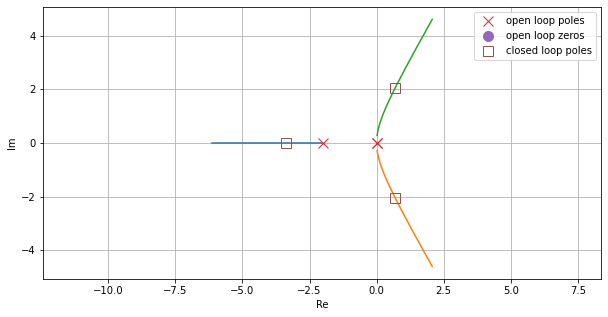

In [71]:
my_root_locus(G, kvect=np.logspace(-2, 1, 1000));

# PID controller

We will do the controller design with MATLAB SIMULINK

The design requirements for the system will be defined to be the following for a step response 
$\zeta =0\ldotp 7071$

$t_s =1.0$

Which imply 

$\%OS=exp{\left(\frac{-\zeta \pi }{\sqrt{1-\zeta {\;}^2 }}\right)}\times 100 = 4.3217 \%$

$\text{time constant} := {4.6}\tau = t_s \leq 1.0 s$
$\Rightarrow \tau \leq 0.2174$


Now using the Control System Tuner of MATLAB we can design a PID with the following gains 

$K_p +K_i \frac{1}{s}+K_d \frac{s}{T_f s+1}$

<span style="color:red">CAUTION: THESE VALUES CORRESPOND TO THE PARAMETERS THAT PROF GOPPERT SET!</span>

$where \phantom{-} K_p =9.37\text{e}-8, \phantom{-} K_i =5.08\text{e}-11,\phantom{-} K_d =0.4683,\phantom{-} T_f =0.00543$

for the system without the noise and disturbance included during the tuning

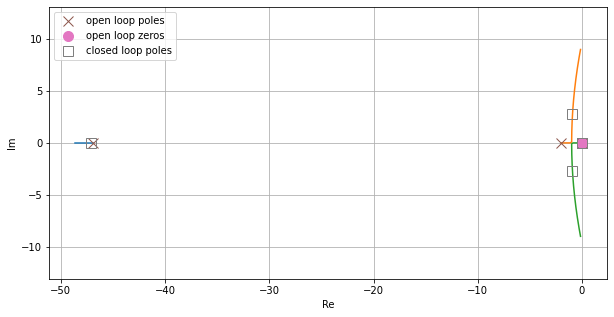

In [72]:
# H = 0.29*(s/1 + 1)/(s/30 + 1)  # lead-lag

kp = 1.06871735994522e-07
ki = 2.16100485542201e-09 
kd = 0.532021304022898
N = 46.9579930140891
H = kp + ki / s + kd * (N / (1 + N * (1 / s)))

my_root_locus(G*H, np.logspace(-10, 1, 1000))

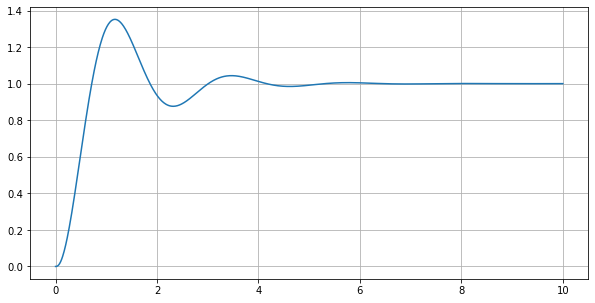

In [73]:
y_r = G*H/(1 + G*H)
t, y = control.step_response(y_r, T=np.linspace(0, 10, 1000))
plt.plot(t, y)
plt.grid()

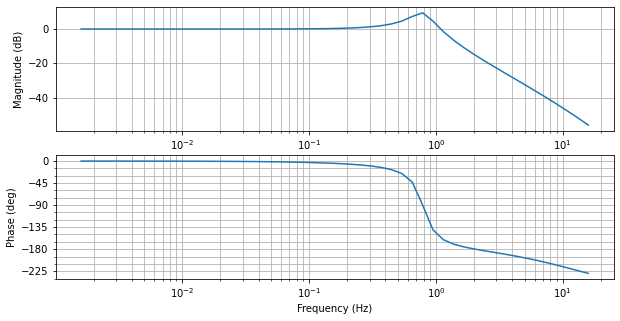

In [23]:
control.bode(y_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

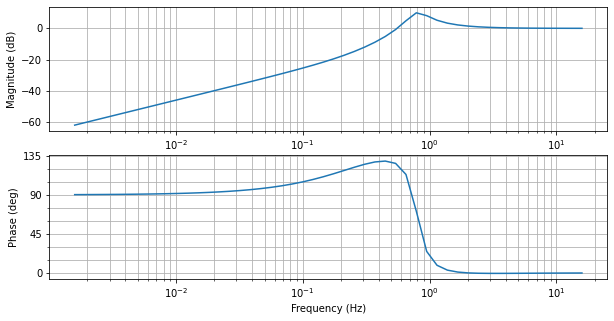

In [24]:
e_r = 1/(1 + G*H)
control.bode(e_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

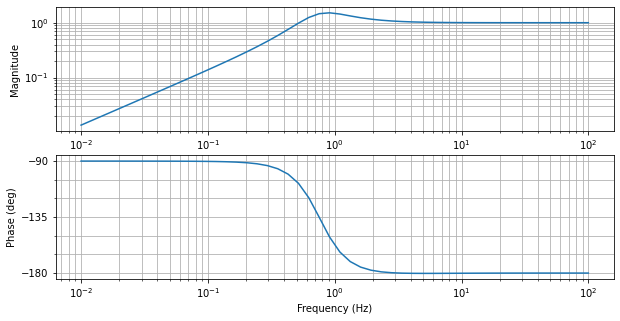

In [25]:
e_n = -1/(1 + Gk*Gf*H)
control.bode(e_n, omega=2*np.pi*np.logspace(-2, 2), Hz=True);

The maximum magnitude is (dB)
3.1350670511759096
The corresponding frequency is (Hz)
4.941713361323833
The gain margin [dB]:
inf
The phase margin [Hz]:
-177.79309795335607

The maximum amplitude is:
1.434674412004357


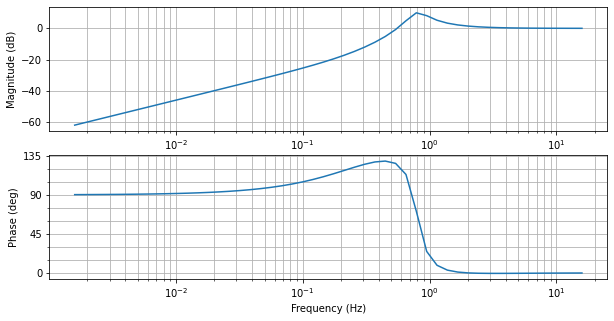

In [26]:
e_d = 1/(1 + G*H)
mag, phase, omega = control.bode(e_d, omega=np.logspace(-2, 2), Hz=True, dB=True);

mag = np.array(mag)
omega = np.array(omega)
max_idx = np.argmax(mag)
print("The maximum magnitude is (dB)")
print(mag[max_idx])
print("The corresponding frequency is (Hz)")
print(omega[max_idx])

# Obtain the phase margins and gain margins 
gm, pm, sm, wg, wp, ws = control.stability_margins((mag, phase, omega))
print("The gain margin [dB]:")
print(gm)
print("The phase margin [Hz]:")
print(pm)

# Compute the maximum amplitude from the bode plot 
Amax = 10 ** (mag[max_idx] / 20)
print("\nThe maximum amplitude is:")
print(Amax)

# Pitch Control 

The Rolls Royce Pegasus 

* cold post/hot post airflow ratio $x_{cp}$/$x_{hp}$
* $d_hp$ distance of the hot post of the engine from the lateral axis which goes through the CG
* $d_cp$ distance of the cold post of the engine from the lateral axis which goes through the CG 

Also assume that the airflow ratio of the hot and cold posts offset the distance of them from the lateral axis. Thus

$d \approx x_{cp}d_{cp} = x_{hp}d_{hp} $

Fan 1st order plant model, taking into account spool up time.

$G_{fan} = \dfrac{F}{u_{fan}} = F_{max} \dfrac{\tau}{s + \tau}$

where:

* $F_{max}$ is the fan maximum thrust (for Rolls Royce Pegasus 71.22 kN)
* $\tau$ is the spool up/spool down time for the fan, assumed to be the same here
* $u_{fan}$ is the normalized [0-1] throttle command for the fan

For the spool up/down time, there is a requirement for aircrafts to be able to acheive thrust power from idle to TOGA in 6 seconds.

Thus, it would be realistic to use values of 10 - 12 seconds for the aircraft to get $F_{max}$

In [54]:
tau = 5
thrust_max = 71.22e3    # the acutal value is 71.22e3 [N]
s = control.tf([1, 0], [1])
G_fan = thrust_max*(tau/(s+tau))
G_fan

TransferFunction(array([356100.]), array([1, 5]))

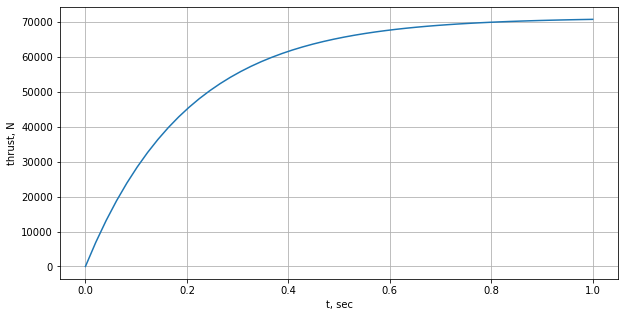

In [55]:
t, y = control.step_response(G_fan, T=np.linspace(0, 1));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('thrust, N')
plt.grid()

## Kinematics of Aircraft pitch

$M = J_{yy} \ddot{\theta}$

$M = J_{yy} s^2 \Theta$

$G_{pitch} = \dfrac{\Theta}{M} = \dfrac{1}{J_{yy} s^2}$

## Mixing

$M = d_{cp}F_{cp} - d_{hp}F_{hp}$

where $F_{cp}$ and $F_{hp}$ are the thrust from the cold post and hot post respectively

here 

$F_{cp} = x_{cp}F$ and $F_{hp} = x_{hp}F$

$M = x_{cp}Fd_{cp} - x_{hp}Fd_{hp}$

$M = x_{cp}d_{cp}G_{fan} u_{cp} - x_{hp}d_{hp} G_{fan} u_{hp}$

since $d = x_{cp}d_{cp} = x_{hp}d_{hp}$

$M = G_{fan} d (u_{cp} - u_{hp})$

$u_{pitch} = u_{cp} + u_{hp}$

$\dfrac{M}{u_{pitch}} =  dG_{fan}$

## Plant Model

$ G = \dfrac{\Theta}{u_{pitch}} = \dfrac{\Theta}{M} \times \dfrac{M}{u_{pitch}} = \dfrac{dF_{max}\tau}{J_{yy}s^2(s+\tau)} $

In [67]:
# Airflow ratio
rcp = 0.5
rhp = 0.5 
# Distances of each post from the lateral axis 
dcp = 1.181
dhp = 1.105
# mean distance 
if round(dcp*rcp) == round(dhp*rhp):
    d = rcp * dcp
else:
    d = (rcp * dcp + rhp * dhp) / 2


Jyy = Ixx + Izz
Gk = 1/(Jyy*s**2)  # Plant for the "k"inematics
Gf = d*G_fan  # Plant for the "f"an
G = Gf * Gk
G

TransferFunction(array([210277.05]), array([107970.275, 539851.375,      0.   ,      0.   ]))

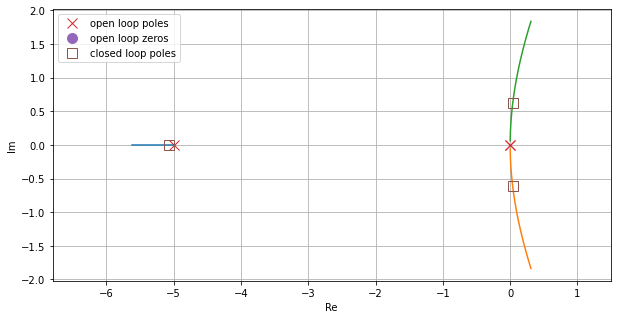

In [59]:
my_root_locus(G, kvect=np.logspace(-2, 1, 1000));

# PID controller

We will do the controller design with MATLAB SIMULINK

The design requirements for the system will be defined to be the following for a step response 
$\zeta =0\ldotp 7071$

$t_s =1.0$

Which imply 

$\%OS=exp{\left(\frac{-\zeta \pi }{\sqrt{1-\zeta {\;}^2 }}\right)}\times 100 = 4.3217 \%$

$\text{time constant} := {4.6}\tau = t_s \leq 1.0 s$
$\Rightarrow \tau \leq 0.2174$


Now using the Control System Tuner of MATLAB we can design a PID with the following gains 

$K_p +K_i \frac{1}{s}+K_d \frac{s}{T_f s+1}$

<span style="color:red">CAUTION: THESE VALUES CORRESPOND TO THE PARAMETERS THAT PROF GOPPERT SET!</span>

$where \phantom{-} K_p =1.8148\text{e}-5, \phantom{-} K_i =1.8117\text{e}-10,\phantom{-} K_d =0.3130,\phantom{-} T_f =0.0421$

for the system without the noise and disturbance included during the tuning

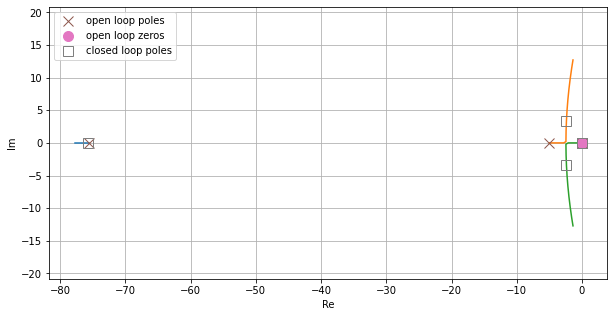

In [60]:
# H = 0.29*(s/1 + 1)/(s/30 + 1)  # lead-lag

kp = 2.44992025334364e-06
ki = 3.06547663120764e-10
kd = 8.65079280777963
N = 75.5192599403064
H = kp + ki / s + kd * (N / (1 + N * (1 / s)))

my_root_locus(G*H, np.logspace(-10, 1, 1000))

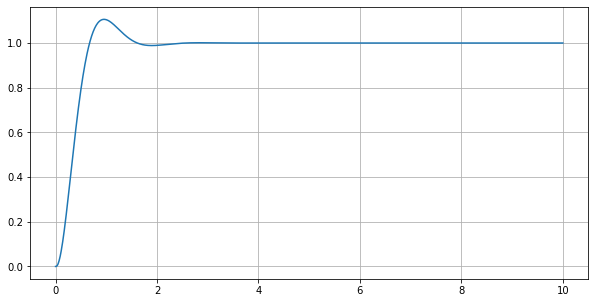

In [61]:
y_r = G*H/(1 + G*H)
t, y = control.step_response(y_r, T=np.linspace(0, 10, 1000))
plt.plot(t, y)
plt.grid()

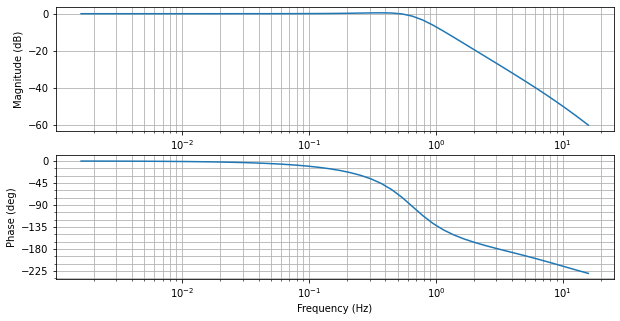

In [62]:
control.bode(y_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

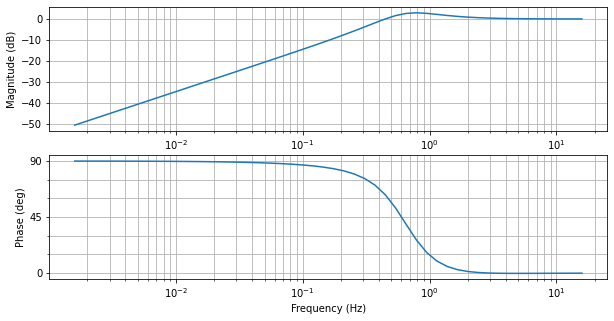

In [63]:
e_r = 1/(1 + G*H)
control.bode(e_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

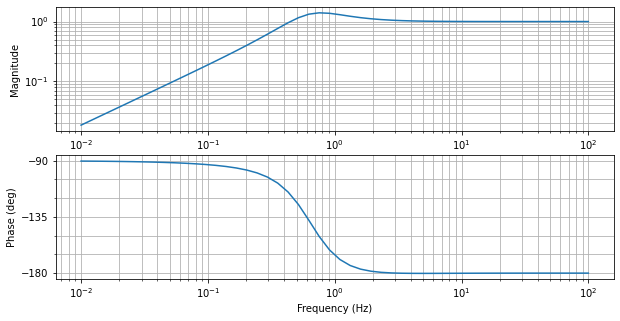

In [64]:
e_n = -1/(1 + Gk*Gf*H)
control.bode(e_n, omega=2*np.pi*np.logspace(-2, 2), Hz=True);

The maximum magnitude is (dB)
1.399822244484404
The corresponding frequency is (Hz)
4.941713361323833
The gain margin [dB]:
inf
The phase margin [Hz]:
-178.90131943117316

The maximum amplitude is:
1.1748735110715574


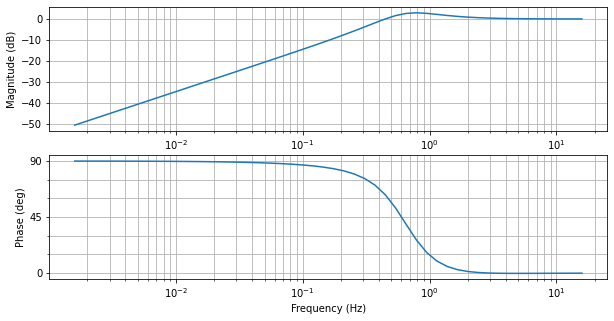

In [65]:
e_d = 1/(1 + G*H)
mag, phase, omega = control.bode(e_d, omega=np.logspace(-2, 2), Hz=True, dB=True);

mag = np.array(mag)
omega = np.array(omega)
max_idx = np.argmax(mag)
print("The maximum magnitude is (dB)")
print(mag[max_idx])
print("The corresponding frequency is (Hz)")
print(omega[max_idx])

# Obtain the phase margins and gain margins 
gm, pm, sm, wg, wp, ws = control.stability_margins((mag, phase, omega))
print("The gain margin [dB]:")
print(gm)
print("The phase margin [Hz]:")
print(pm)


# Compute the maximum amplitude from the bode plot 
Amax = 10 ** (mag[max_idx] / 20)
print("\nThe maximum amplitude is:")
print(Amax)